# Evolved Rule


In [ ]:
#@title Downloading necessary files
# !conda install -q -y ffmpeg
!wget -q https://dl3.pushbulletusercontent.com/VvNdOmD3SRsIGnP8lCniQf3BJzX7kgRL/neighborhoods.zip
!unzip -q neighborhoods.zip
!rm -rf __MACOSX/
!rm neighborhoods.zip



In [ ]:
#@title Setting rules
rule = [[(0.451, 0.713, 0), (0.449, 0.663, 1), (0.191, 0.52, 1), (0.089, 0.296, 0)],
        [(0.332, 0.51, 0), (0.084, 0.307, 0), (0.182, 0.465, 1)],
        [(0.799, 0.902, 0), (0.303, 0.456, 0), (0.835, 0.984, 1)]]

Definition of the variables for setting the configuration

- blocksize: size of the block that is used for coarse graining. For example, block size 2 will reduce the size of grid to half, that is 100x100 grid will reduce to 50x50. These values can range from 2 to 4, in our implementation

- upper_alpha: the lower bound for multi state coarse graining threshold. This value should be smaller than lower alpha. This works as lower threshold

- lower_alpha: the upper bound for multi state coarse graining threshold. This value should be larger than upper alpha. This works as upper threshold

- width: grid size width, defalut 100

- height: grid size height, defalut 100

- steps: time steps, for which simulation of CA runs. For example, 9 steps equals to 9 frames of simulation with 9 respective updates.

- initial_state_probability: The density of pixels populated initially for starting frame.

- seed_value: This value initialise the random pixels for the board as same in simulations. defalut as 1, if changed, behaviour will be different. It preserves the states, so that same pixel density could be understood for histograms and FHCG.

- maximum_plot_thresh_fhcg: This value decides the limit of y-axis so as to skip extra high bars to increase the readablity of the FHCG plots.

- number_of_states: The number of states in FHCG which are coarse grained and binary states wiht greyish pixels (with decimal value pixels) are put in the CG output. Further details of number of states are in next paragraph.

- Realised Number of States = Number of States entered - 1

For example:

- 3 states entered = 2 states realised (No horizontal line in histogram)

- 4 states entered = 3 states realised (2 horizontal lines in histogram)

- 5 states entered = 4 states realised (3 horizontal lines in histogram)

and so on...

In [ ]:
#@title MNCA Configuration (default is best configuration found so far at threshold 0.025)

blocksize = 2 #@param {type:"slider", min:1, max:4, step:1}
upper_alpha = 0.005 #@param {type:"slider", min:0, max:0.1, step:0.001}
lower_alpha = 0.062 #@param {type:"slider", min:0, max:0.1, step:0.001}
width = 100 #@param {type:"slider", min:50, max:120, step:1}
height = 100 #@param {type:"slider", min:50, max:120, step:1}
steps = 9 #@param {type:"slider", min:0, max:100, step:1}
initial_state_probability = 0.06 #@param {type:"slider", min:0, max:1, step:0.01}
seed_value = 1 #@param {type: "number"}
minimum_plot_thresh_fhcg = 0
maximum_plot_thresh_fhcg = 0.15 #@param {type:"slider", min:0.1, max:0.3, step:0.01}
number_of_states = 5 #@param {type:"slider", min:3, max:10, step:1}

In [ ]:
#@title Check for width and height adjustment
# Check width, height whether divisible by 2 or 3
# Slice width and height accordingly

def adjust_dimensions(blocksize, width, height):
    if blocksize == 2:
        width = (width // 2) * 2  # Round down to the nearest multiple of 2
        height = (height // 2) * 2
    elif blocksize == 3:
        width = (width // 3) * 3  # Round down to the nearest multiple of 3
        height = (height // 3) * 3
    return width, height

width, height = adjust_dimensions(blocksize, width, height)
# print(f"Adjusted width: {width}")
# print(f"Adjusted height: {height}")
# print(f"block size: {blocksize}")


In [ ]:
#@title Generate HD gif and save array information
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from collections import Counter

# Preserving the board state, rather than saving the physical data of board states, lets just save the random seed!
# At least for 2D we can do that because, we just need to assign a known random seed and perform coarse graining over different thresholds
# testing different thresholds could be done on the same rule and board states by saving random seed and hence initialising the board with
# same initial state.
np.random.seed(seed_value)


############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
def blockshaped(arr, nrows, ncols):

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))



import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

def FrequencyHistogramCoarseGraining(array_3d):
    time_steps,width,height = array_3d.shape
    # Let us split NxN array to smaller 2x2 blcks
    super_cells_list_volumetric =  []
    new_board_volumetric_supercells_list = []
    # threshold1 = threshold
    # what are the lower limits of thresh and upper limits of thresh?
    # threshold2 = 0.06 # For multi state MNCA
    lower = lower_alpha
    upper = upper_alpha
    n = number_of_states
    range_size = (upper - lower) / n
    boundaries = [lower + i * range_size for i in range(n+1)]
    parts = []
    for i in range(n):
      parts.append(boundaries[i])

    thresholds = parts
    # given block shape of 2,2 says that we have a chunk of 2x2 that partitions complete w,h

    for grid_2d in array_3d:
      blocked_grid_2d = blockshaped(grid_2d,blocksize,blocksize)
      for each_sub_array in blocked_grid_2d:
        super_cells_list_volumetric.append(list(each_sub_array.flatten()))
    test_array=np.array(super_cells_list_volumetric)
    # print(test_array.shape)
    for i in range(len(super_cells_list_volumetric)):
      count = 0
      for j in range(len(super_cells_list_volumetric)):
        if(super_cells_list_volumetric[i]==super_cells_list_volumetric[j]):
          count = count+1 # count is number of blocks matching in the same grid (ref literature)
      new_board_volumetric_supercells_list.append(count/len(super_cells_list_volumetric))

    a = super_cells_list_volumetric
    total = len(a)
    freq = Counter(map(tuple, a))
    prob = {k: v / total for k, v in freq.items()}
    sorted_prob = dict(sorted(prob.items(), key=lambda x: x[0]))

    plt.bar(range(len(sorted_prob)), list(sorted_prob.values()))
    plt.xticks(range(len(sorted_prob)), [int(''.join(map(str, k)), 2) for k in sorted_prob.keys()])
    plt.xlabel('Decimal Values of the binary values in block')
    plt.ylabel('Probability of occurrence')
    plt.title('Probability of occurrence of supercells vs (Decimal Values)')
    plt.yticks([i / 20 for i in range(21)], [f'{i / 20:.2f}' for i in range(21)])
    # plt.hlines(upper,xmin=range(len(prob))[0],xmax=range(len(prob))[-1], colors='r', linestyles='dashed') # drawing straight line for threshold
    # plt.hlines(lower,xmin=range(len(prob))[0],xmax=range(len(prob))[-1], colors='r', linestyles='dashed') # drawing straight line for threshold
    if(number_of_states>3):
      for each_part in parts:
        if(each_part == parts[0] or each_part == parts[-1]):
          pass
        else:
          plt.hlines(each_part,xmin=range(len(prob))[0],xmax=range(len(prob))[-1], colors='r', linestyles='dashed') # drawing straight line for threshold
    else:
      pass
    plt.ylim(minimum_plot_thresh_fhcg, maximum_plot_thresh_fhcg)


    plt.savefig("histogram.jpg")
    plt.close()
    ################################################################
    dynamic_states = list(np.linspace(1,0,n))
    for k in range(len(new_board_volumetric_supercells_list)):
      for z in range(len(thresholds)-1,0,-1):
        if(thresholds[z]<=new_board_volumetric_supercells_list[k]<=thresholds[z-1]):
          new_board_volumetric_supercells_list[k]=dynamic_states[z]

    ################################################################
    modified_board = np.array(new_board_volumetric_supercells_list)
    shape = int(np.sqrt(len(new_board_volumetric_supercells_list) / time_steps))
    modified_board_return = modified_board.reshape(time_steps, shape, shape)
    return modified_board_return




############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############
############# FHCG SECTION ##############



def init_board(width, height, init_state):
    if init_state == "single cell in center":
        board = np.zeros((height, width), dtype=np.int)
        board[height//2, width//2] = 1
    elif init_state == "random cells with some probability":
        p = initial_state_probability # probability of a cell being alive
        board = np.random.choice([0, 1], size=(height, width), p=[1-p, p])
    elif init_state == "random cells with 2 different states":
        p1 = 0.250 # probability of a cell being state 1
        board = np.random.choice([0, 1, 2], size=(height, width), p=[1-p1, p1/2, p1/2])
    else:
        raise ValueError("Invalid initial state")
    return board

volume_board_data = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums):
    new_board = np.zeros_like(board, dtype=int)
    height, width = board.shape
    for i in range(height):
        for j in range(width):
            next_state = board[i, j]
            for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
                cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                     for ni, nj in neighborhood]

                # # use this for sum
                # neighborhood_sum = sum(cell_neighborhood)

                # use this for average
                neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
                for lower, upper, new_next_state in range_of_neighborhood_sum:
                    if lower <= neighborhood_sum <= upper:
                        next_state = new_next_state
            new_board[i, j] = next_state
    board[:] = new_board[:]
    # board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
    import copy
    volume_board_data.append(copy.deepcopy(board)) # Collecting boaards in a list for coarse grianing
    img.set_data(board)
    return img,

def run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums):
    board = init_board(width, height, init_state)
    fig, ax = plt.subplots()
    plt.axis('off')
    img = ax.imshow(board, cmap='binary')
    ani = animation.FuncAnimation(fig, update, frames=steps, fargs=(img, board, neighborhoods, range_of_neighborhood_sums), repeat=False)
    ani.save(filename, writer='pillow')
    # ani.save(filename, writer='ffmpeg', codec='h264')
    plt.close()



def extract_neighborhood_from_file(file_name):
    with open(file_name, "r") as f:
        lines = f.readlines()
        neighborhood = []
        for i, line in enumerate(lines):
            line = line.strip()
            for j, value in enumerate(line.split(" ")):
                if value == "1":
                    neighborhood.append((i-1, j-1))
        return neighborhood


init_state = "random cells with some probability"




nh1 = extract_neighborhood_from_file('neighborhoods/mask_c1.txt')
nh2 = extract_neighborhood_from_file('neighborhoods/mask_c2.txt')
nh3 = extract_neighborhood_from_file('neighborhoods/mask_c3.txt')
neighborhoods = [nh1,nh2,nh3]
range_of_neighborhood_sums=rule



filename = "animation_hd.gif"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)
import base64
from IPython.display import HTML, display

def display_gif_with_centered_caption(filename, caption):
    with open(filename, 'rb') as f:
        data = f.read()
        encoded = base64.b64encode(data).decode('ascii')
        html = f'''
        <figure style="text-align: center;">
            <img src="data:image/gif;base64,{encoded}" alt="gif" style="display: block; margin: 0 auto;">
            <figcaption style="text-align: center; margin-top: 10px;">{caption}</figcaption>
        </figure>
        '''
        display(HTML(html))

# display_gif_with_centered_caption('animation_hd.gif', 'Non Coarse Grained MNCA')




In [ ]:
#@title Converting to np array
import numpy as np
grid_array = np.array(volume_board_data)
# print(grid_array.shape)


In [ ]:
#@title Create GIF Function
from PIL import Image
import os

def create_gif(directory, output_filename):
    filenames = [f for f in os.listdir(directory) if f.endswith('.png')]
    filenames.sort(key=lambda x: int(x[:-4]))
    with Image.open(os.path.join(directory, filenames[0])) as im:
        sequence = [Image.open(os.path.join(directory, f)) for f in filenames]

        sequence[0].save(output_filename,
                         save_all=True,
                         append_images=sequence[1:],
                         duration=100,      # Duration of each frame (in ms)
                         loop=0)            # Number of loops (0 means infinite)





In [ ]:
#@title Perform FHCG
import os
fhcg = FrequencyHistogramCoarseGraining(grid_array)
# print(fhcg.shape)
for i in range(len(fhcg)):
  plt.imshow(fhcg[i],cmap="gist_gray")
  filename = "{:04d}.png".format(i)
  plt.savefig(filename)
  plt.close()
create_gif('.', 'animation_cg.gif')
os.system("rm *.png")

0

In [ ]:
#@title Displaying results with zoom functionality

import base64
from IPython.display import HTML, display
import os


dir_path = './'


gif_files = [f for f in os.listdir(dir_path) if f.endswith('.gif') and f.startswith('animation_cg')]
jpg_files = [f for f in os.listdir(dir_path) if f.endswith('.jpg') and f.startswith('histogram')]


gif_files.sort()
jpg_files.sort()


gifs = []
jpgs = []
file_names = []
jpg_names = []
for gif_file, jpg_file in zip(gif_files, jpg_files):
    gif_path = os.path.join(dir_path, gif_file)
    jpg_path = os.path.join(dir_path, jpg_file)

    with open(gif_path, 'rb') as f:
        gif_encoded = base64.b64encode(f.read()).decode('ascii')
    with open(jpg_path, 'rb') as f:
        jpg_encoded = base64.b64encode(f.read()).decode('ascii')

    file_name = gif_file.split('/')[-1]

    gifs.append(gif_encoded)
    jpgs.append(jpg_encoded)
    file_names.append(file_name)
    jpg_names.append(jpg_path.split('/')[-1])


fixed_file = 'animation_hd.gif'
fixed_file_path = os.path.join(dir_path, fixed_file)

with open(fixed_file_path, 'rb') as f:
    fixed_file_encoded = base64.b64encode(f.read()).decode('ascii')


slider = """
<style>
.slider-container {{
  display: flex;
  align-items: center;
  justify-content: center;
}}

.slider {{
  -webkit-appearance: none;
  appearance: none;
  width: 200px;
  height: 10px;
  background: #f1f1f1;
  outline: none;
  opacity: 0.7;
  -webkit-transition: .2s;
  transition: opacity .2s;
}}

.slider::-webkit-slider-thumb {{
  -webkit-appearance: none;
  appearance: none;
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}

.slider::-moz-range-thumb {{
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}
</style>

<script>
function zoomImage(event) {{
  var img = event.target;
  var posX = event.clientX;
  var posY = event.clientY;
  var rect = img.getBoundingClientRect();
  var offsetX = posX - rect.left;
  var offsetY = posY - rect.top;
  var zoomFactor = 4;
  var scale = "scale(" + zoomFactor + ")";
  var transformOrigin = offsetX + "px " + offsetY + "px";

  img.style.transform = scale;
  img.style.transformOrigin = transformOrigin;
}}

function resetImage(event) {{
  var img = event.target;
  img.style.transform = "";
  img.style.transformOrigin = "";
}}
</script>

<div class="slider-container">
  <input type="range" min="0" max="{max_val}" step="1" value="0" id="slider" class="slider">
  <p style="margin-top: 10px; font-weight: bold;" id="value_text">{value}</p>
</div>
"""

output_div = "<div id='output' style='display:flex;justify-content:center;'></div>"

script = """
<script>
var values = {values};
var fileNames = {file_names};
var jpgNames = {jpg_names};
var gifs = {gifs};
var jpgs = {jpgs};
var fixedFile = '{fixed_file}';
var fixedFileEncoded = '{fixed_file_encoded}';

function updateOutput() {{
  var slider = document.getElementById('slider');
  var output = document.getElementById('output');
  var valueText = document.getElementById('value_text');

  var selectedIndex = slider.value;
  var html = '<div style="display:flex; flex-direction:row;">' +
             '<div style="text-align:center;">' +
             '<img src="data:image/jpeg;base64,' + jpgs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + jpgNames[selectedIndex] + '</p>' +
             '</div>' +
             '<div style="text-align:center;">' +
             '<img src="data:image/gif;base64,' + gifs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + fileNames[selectedIndex] + '</p>' +
             '</div>' +
             '</div>';

  var fixedHtml = '<div style="text-align:center;">' +
                  '<img src="data:image/gif;base64,' + fixedFileEncoded + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
                  '<p>' + fixedFile + '</p>' +
                  '</div>';

  output.innerHTML = html + fixedHtml;
  valueText.textContent = values[selectedIndex];
}}

var slider = document.getElementById('slider');
slider.addEventListener('input', updateOutput);
updateOutput();
</script>
"""

display(HTML(slider.format(max_val=len(gifs) - 1, value=file_names[0])))
display(HTML(output_div))

display(HTML(script.format(gifs=gifs, jpgs=jpgs, values=file_names, file_names=file_names, jpg_names=jpg_names,
                           fixed_file=fixed_file, fixed_file_encoded=fixed_file_encoded)))


# GoL

In [ ]:
#@title Setting rules
!rm *.jpg
!rm *.gif
rule = [[(0, 1, 0), (3, 3, 1), (4, 8, 0)]] # GoL

In [ ]:
#@title Setting Thresholds
upper_alpha = 0.002 #@param {type:"slider", min:0, max:0.1, step:0.001}
lower_alpha = 0.02 #@param {type:"slider", min:0, max:0.1, step:0.001}
initial_state_probability = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}


In [ ]:
#@title Cellular Automata update function for neighborhood sum rule
volume_board_data = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums):
    new_board = np.zeros_like(board, dtype=int)
    height, width = board.shape
    for i in range(height):
        for j in range(width):
            next_state = board[i, j]
            for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
                cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                     for ni, nj in neighborhood]

                # # use this for sum
                neighborhood_sum = sum(cell_neighborhood)

                # use this for average
                # neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
                for lower, upper, new_next_state in range_of_neighborhood_sum:
                    if lower <= neighborhood_sum <= upper:
                        next_state = new_next_state
            new_board[i, j] = next_state
    board[:] = new_board[:]
    # board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
    import copy
    volume_board_data.append(copy.deepcopy(board)) # Collecting boaards in a list for coarse grianing
    img.set_data(board)
    return img,

In [ ]:
#@title Run CA for GoL HD

nh1 = extract_neighborhood_from_file('neighborhoods/8_neighbor.txt')
neighborhoods = [nh1]
range_of_neighborhood_sums=rule
filename = "animation_hd.gif"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)
grid_array = np.array(volume_board_data)

In [ ]:
#@title Perform FHCG
import os
fhcg = FrequencyHistogramCoarseGraining(grid_array)
# print(fhcg.shape)
for i in range(len(fhcg)):
  plt.imshow(fhcg[i],cmap="gist_gray")
  filename = "{:04d}.png".format(i)
  plt.savefig(filename)
  plt.close()
create_gif('.', 'animation_cg.gif')
os.system("rm *.png")

0

In [ ]:
#@title Displaying results with zoom functionality

import base64
from IPython.display import HTML, display
import os


dir_path = './'


gif_files = [f for f in os.listdir(dir_path) if f.endswith('.gif') and f.startswith('animation_cg')]
jpg_files = [f for f in os.listdir(dir_path) if f.endswith('.jpg') and f.startswith('histogram')]


gif_files.sort()
jpg_files.sort()


gifs = []
jpgs = []
file_names = []
jpg_names = []
for gif_file, jpg_file in zip(gif_files, jpg_files):
    gif_path = os.path.join(dir_path, gif_file)
    jpg_path = os.path.join(dir_path, jpg_file)

    with open(gif_path, 'rb') as f:
        gif_encoded = base64.b64encode(f.read()).decode('ascii')
    with open(jpg_path, 'rb') as f:
        jpg_encoded = base64.b64encode(f.read()).decode('ascii')

    file_name = gif_file.split('/')[-1]

    gifs.append(gif_encoded)
    jpgs.append(jpg_encoded)
    file_names.append(file_name)
    jpg_names.append(jpg_path.split('/')[-1])


fixed_file = 'animation_hd.gif'
fixed_file_path = os.path.join(dir_path, fixed_file)

with open(fixed_file_path, 'rb') as f:
    fixed_file_encoded = base64.b64encode(f.read()).decode('ascii')


slider = """
<style>
.slider-container {{
  display: flex;
  align-items: center;
  justify-content: center;
}}

.slider {{
  -webkit-appearance: none;
  appearance: none;
  width: 200px;
  height: 10px;
  background: #f1f1f1;
  outline: none;
  opacity: 0.7;
  -webkit-transition: .2s;
  transition: opacity .2s;
}}

.slider::-webkit-slider-thumb {{
  -webkit-appearance: none;
  appearance: none;
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}

.slider::-moz-range-thumb {{
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}
</style>

<script>
function zoomImage(event) {{
  var img = event.target;
  var posX = event.clientX;
  var posY = event.clientY;
  var rect = img.getBoundingClientRect();
  var offsetX = posX - rect.left;
  var offsetY = posY - rect.top;
  var zoomFactor = 4;
  var scale = "scale(" + zoomFactor + ")";
  var transformOrigin = offsetX + "px " + offsetY + "px";

  img.style.transform = scale;
  img.style.transformOrigin = transformOrigin;
}}

function resetImage(event) {{
  var img = event.target;
  img.style.transform = "";
  img.style.transformOrigin = "";
}}
</script>

<div class="slider-container">
  <input type="range" min="0" max="{max_val}" step="1" value="0" id="slider" class="slider">
  <p style="margin-top: 10px; font-weight: bold;" id="value_text">{value}</p>
</div>
"""

output_div = "<div id='output' style='display:flex;justify-content:center;'></div>"

script = """
<script>
var values = {values};
var fileNames = {file_names};
var jpgNames = {jpg_names};
var gifs = {gifs};
var jpgs = {jpgs};
var fixedFile = '{fixed_file}';
var fixedFileEncoded = '{fixed_file_encoded}';

function updateOutput() {{
  var slider = document.getElementById('slider');
  var output = document.getElementById('output');
  var valueText = document.getElementById('value_text');

  var selectedIndex = slider.value;
  var html = '<div style="display:flex; flex-direction:row;">' +
             '<div style="text-align:center;">' +
             '<img src="data:image/jpeg;base64,' + jpgs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + jpgNames[selectedIndex] + '</p>' +
             '</div>' +
             '<div style="text-align:center;">' +
             '<img src="data:image/gif;base64,' + gifs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + fileNames[selectedIndex] + '</p>' +
             '</div>' +
             '</div>';

  var fixedHtml = '<div style="text-align:center;">' +
                  '<img src="data:image/gif;base64,' + fixedFileEncoded + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
                  '<p>' + fixedFile + '</p>' +
                  '</div>';

  output.innerHTML = html + fixedHtml;
  valueText.textContent = values[selectedIndex];
}}

var slider = document.getElementById('slider');
slider.addEventListener('input', updateOutput);
updateOutput();
</script>
"""

display(HTML(slider.format(max_val=len(gifs) - 1, value=file_names[0])))
display(HTML(output_div))

display(HTML(script.format(gifs=gifs, jpgs=jpgs, values=file_names, file_names=file_names, jpg_names=jpg_names,
                           fixed_file=fixed_file, fixed_file_encoded=fixed_file_encoded)))


# High Life

In [ ]:
#@title Setting rules
!rm *.jpg
!rm *.gif
rule = [[(0, 1, 0), (3, 3, 1), (6, 6, 1), (4, 8, 0)]] # GoL

In [ ]:
#@title Setting Thresholds

upper_alpha = 0.002 #@param {type:"slider", min:0, max:0.1, step:0.001}
lower_alpha = 0.06 #@param {type:"slider", min:0, max:0.1, step:0.001}
initial_state_probability = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}


In [ ]:
#@title Cellular Automata update function for neighborhood sum rule
volume_board_data = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums):
    new_board = np.zeros_like(board, dtype=int)
    height, width = board.shape
    for i in range(height):
        for j in range(width):
            next_state = board[i, j]
            for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
                cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                     for ni, nj in neighborhood]

                # # use this for sum
                neighborhood_sum = sum(cell_neighborhood)

                # use this for average
                # neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
                for lower, upper, new_next_state in range_of_neighborhood_sum:
                    if lower <= neighborhood_sum <= upper:
                        next_state = new_next_state
            new_board[i, j] = next_state
    board[:] = new_board[:]
    # board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
    import copy
    volume_board_data.append(copy.deepcopy(board)) # Collecting boaards in a list for coarse grianing
    img.set_data(board)
    return img,

In [ ]:
#@title Run CA for High Life HD

nh1 = extract_neighborhood_from_file('neighborhoods/8_neighbor.txt')
neighborhoods = [nh1]
range_of_neighborhood_sums=rule
filename = "animation_hd.gif"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)
grid_array = np.array(volume_board_data)

In [ ]:
#@title Perform FHCG
import os
fhcg = FrequencyHistogramCoarseGraining(grid_array)
# print(fhcg.shape)
for i in range(len(fhcg)):
  plt.imshow(fhcg[i],cmap="gist_gray")
  filename = "{:04d}.png".format(i)
  plt.savefig(filename)
  plt.close()
create_gif('.', 'animation_cg.gif')
os.system("rm *.png")

0

In [ ]:
#@title Displaying results with zoom functionality

import base64
from IPython.display import HTML, display
import os


dir_path = './'


gif_files = [f for f in os.listdir(dir_path) if f.endswith('.gif') and f.startswith('animation_cg')]
jpg_files = [f for f in os.listdir(dir_path) if f.endswith('.jpg') and f.startswith('histogram')]


gif_files.sort()
jpg_files.sort()


gifs = []
jpgs = []
file_names = []
jpg_names = []
for gif_file, jpg_file in zip(gif_files, jpg_files):
    gif_path = os.path.join(dir_path, gif_file)
    jpg_path = os.path.join(dir_path, jpg_file)

    with open(gif_path, 'rb') as f:
        gif_encoded = base64.b64encode(f.read()).decode('ascii')
    with open(jpg_path, 'rb') as f:
        jpg_encoded = base64.b64encode(f.read()).decode('ascii')

    file_name = gif_file.split('/')[-1]

    gifs.append(gif_encoded)
    jpgs.append(jpg_encoded)
    file_names.append(file_name)
    jpg_names.append(jpg_path.split('/')[-1])


fixed_file = 'animation_hd.gif'
fixed_file_path = os.path.join(dir_path, fixed_file)

with open(fixed_file_path, 'rb') as f:
    fixed_file_encoded = base64.b64encode(f.read()).decode('ascii')


slider = """
<style>
.slider-container {{
  display: flex;
  align-items: center;
  justify-content: center;
}}

.slider {{
  -webkit-appearance: none;
  appearance: none;
  width: 200px;
  height: 10px;
  background: #f1f1f1;
  outline: none;
  opacity: 0.7;
  -webkit-transition: .2s;
  transition: opacity .2s;
}}

.slider::-webkit-slider-thumb {{
  -webkit-appearance: none;
  appearance: none;
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}

.slider::-moz-range-thumb {{
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}
</style>

<script>
function zoomImage(event) {{
  var img = event.target;
  var posX = event.clientX;
  var posY = event.clientY;
  var rect = img.getBoundingClientRect();
  var offsetX = posX - rect.left;
  var offsetY = posY - rect.top;
  var zoomFactor = 4;
  var scale = "scale(" + zoomFactor + ")";
  var transformOrigin = offsetX + "px " + offsetY + "px";

  img.style.transform = scale;
  img.style.transformOrigin = transformOrigin;
}}

function resetImage(event) {{
  var img = event.target;
  img.style.transform = "";
  img.style.transformOrigin = "";
}}
</script>

<div class="slider-container">
  <input type="range" min="0" max="{max_val}" step="1" value="0" id="slider" class="slider">
  <p style="margin-top: 10px; font-weight: bold;" id="value_text">{value}</p>
</div>
"""

output_div = "<div id='output' style='display:flex;justify-content:center;'></div>"

script = """
<script>
var values = {values};
var fileNames = {file_names};
var jpgNames = {jpg_names};
var gifs = {gifs};
var jpgs = {jpgs};
var fixedFile = '{fixed_file}';
var fixedFileEncoded = '{fixed_file_encoded}';

function updateOutput() {{
  var slider = document.getElementById('slider');
  var output = document.getElementById('output');
  var valueText = document.getElementById('value_text');

  var selectedIndex = slider.value;
  var html = '<div style="display:flex; flex-direction:row;">' +
             '<div style="text-align:center;">' +
             '<img src="data:image/jpeg;base64,' + jpgs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + jpgNames[selectedIndex] + '</p>' +
             '</div>' +
             '<div style="text-align:center;">' +
             '<img src="data:image/gif;base64,' + gifs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + fileNames[selectedIndex] + '</p>' +
             '</div>' +
             '</div>';

  var fixedHtml = '<div style="text-align:center;">' +
                  '<img src="data:image/gif;base64,' + fixedFileEncoded + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
                  '<p>' + fixedFile + '</p>' +
                  '</div>';

  output.innerHTML = html + fixedHtml;
  valueText.textContent = values[selectedIndex];
}}

var slider = document.getElementById('slider');
slider.addEventListener('input', updateOutput);
updateOutput();
</script>
"""

display(HTML(slider.format(max_val=len(gifs) - 1, value=file_names[0])))
display(HTML(output_div))

display(HTML(script.format(gifs=gifs, jpgs=jpgs, values=file_names, file_names=file_names, jpg_names=jpg_names,
                           fixed_file=fixed_file, fixed_file_encoded=fixed_file_encoded)))


# Larger than Life

In [ ]:
#@title Setting rules
!rm *.jpg
!rm *.gif
rule = [[(0, 33, 0), (34, 45, 1), (58, 121, 0)]] # Larger Than Life Slackermanz

In [ ]:
#@title Setting Thresholds
upper_alpha = 0.001 #@param {type:"slider", min:0, max:0.1, step:0.001}
lower_alpha = 0.008 #@param {type:"slider", min:0, max:0.1, step:0.001}
initial_state_probability = 0.53 #@param {type:"slider", min:0, max:1, step:0.01}


In [ ]:
#@title Cellular Automata update function for neighborhood sum rule
volume_board_data = []
def update(frame, img, board, neighborhoods, range_of_neighborhood_sums):
    new_board = np.zeros_like(board, dtype=int)
    height, width = board.shape
    for i in range(height):
        for j in range(width):
            next_state = board[i, j]
            for neighborhood, range_of_neighborhood_sum in zip(neighborhoods, range_of_neighborhood_sums):
                cell_neighborhood = [board[(i + ni + height) % height, (j + nj + width) % width]
                                     for ni, nj in neighborhood]

                # # use this for sum
                neighborhood_sum = sum(cell_neighborhood)

                # use this for average
                # neighborhood_sum = sum(cell_neighborhood)/len(cell_neighborhood)
                for lower, upper, new_next_state in range_of_neighborhood_sum:
                    if lower <= neighborhood_sum <= upper:
                        next_state = new_next_state
            new_board[i, j] = next_state
    board[:] = new_board[:]
    # board = FrequencyHistogramCoarseGraining(board) # Adding coarse grained
    import copy
    volume_board_data.append(copy.deepcopy(board)) # Collecting boaards in a list for coarse grianing
    img.set_data(board)
    return img,

In [ ]:
#@title Run CA for High Life HD

nh1 = extract_neighborhood_from_file('neighborhoods/11x11_larger_than_life.txt')
neighborhoods = [nh1]
range_of_neighborhood_sums=rule
filename = "animation_hd.gif"
run_automaton(width, height, steps, init_state, filename, neighborhoods, range_of_neighborhood_sums)
grid_array = np.array(volume_board_data)

In [ ]:
#@title Perform FHCG
import os
fhcg = FrequencyHistogramCoarseGraining(grid_array)
# print(fhcg.shape)
for i in range(len(fhcg)):
  plt.imshow(fhcg[i],cmap="gist_gray")
  filename = "{:04d}.png".format(i)
  plt.savefig(filename)
  plt.close()
create_gif('.', 'animation_cg.gif')
os.system("rm *.png")

0

In [ ]:
#@title Displaying results with zoom functionality

import base64
from IPython.display import HTML, display
import os


dir_path = './'


gif_files = [f for f in os.listdir(dir_path) if f.endswith('.gif') and f.startswith('animation_cg')]
jpg_files = [f for f in os.listdir(dir_path) if f.endswith('.jpg') and f.startswith('histogram')]


gif_files.sort()
jpg_files.sort()


gifs = []
jpgs = []
file_names = []
jpg_names = []
for gif_file, jpg_file in zip(gif_files, jpg_files):
    gif_path = os.path.join(dir_path, gif_file)
    jpg_path = os.path.join(dir_path, jpg_file)

    with open(gif_path, 'rb') as f:
        gif_encoded = base64.b64encode(f.read()).decode('ascii')
    with open(jpg_path, 'rb') as f:
        jpg_encoded = base64.b64encode(f.read()).decode('ascii')

    file_name = gif_file.split('/')[-1]

    gifs.append(gif_encoded)
    jpgs.append(jpg_encoded)
    file_names.append(file_name)
    jpg_names.append(jpg_path.split('/')[-1])


fixed_file = 'animation_hd.gif'
fixed_file_path = os.path.join(dir_path, fixed_file)

with open(fixed_file_path, 'rb') as f:
    fixed_file_encoded = base64.b64encode(f.read()).decode('ascii')


slider = """
<style>
.slider-container {{
  display: flex;
  align-items: center;
  justify-content: center;
}}

.slider {{
  -webkit-appearance: none;
  appearance: none;
  width: 200px;
  height: 10px;
  background: #f1f1f1;
  outline: none;
  opacity: 0.7;
  -webkit-transition: .2s;
  transition: opacity .2s;
}}

.slider::-webkit-slider-thumb {{
  -webkit-appearance: none;
  appearance: none;
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}

.slider::-moz-range-thumb {{
  width: 28px;
  height: 28px;
  border-radius: 50%;
  background: #4CAF50;
  cursor: pointer;
  box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.5);
}}
</style>

<script>
function zoomImage(event) {{
  var img = event.target;
  var posX = event.clientX;
  var posY = event.clientY;
  var rect = img.getBoundingClientRect();
  var offsetX = posX - rect.left;
  var offsetY = posY - rect.top;
  var zoomFactor = 4;
  var scale = "scale(" + zoomFactor + ")";
  var transformOrigin = offsetX + "px " + offsetY + "px";

  img.style.transform = scale;
  img.style.transformOrigin = transformOrigin;
}}

function resetImage(event) {{
  var img = event.target;
  img.style.transform = "";
  img.style.transformOrigin = "";
}}
</script>

<div class="slider-container">
  <input type="range" min="0" max="{max_val}" step="1" value="0" id="slider" class="slider">
  <p style="margin-top: 10px; font-weight: bold;" id="value_text">{value}</p>
</div>
"""

output_div = "<div id='output' style='display:flex;justify-content:center;'></div>"

script = """
<script>
var values = {values};
var fileNames = {file_names};
var jpgNames = {jpg_names};
var gifs = {gifs};
var jpgs = {jpgs};
var fixedFile = '{fixed_file}';
var fixedFileEncoded = '{fixed_file_encoded}';

function updateOutput() {{
  var slider = document.getElementById('slider');
  var output = document.getElementById('output');
  var valueText = document.getElementById('value_text');

  var selectedIndex = slider.value;
  var html = '<div style="display:flex; flex-direction:row;">' +
             '<div style="text-align:center;">' +
             '<img src="data:image/jpeg;base64,' + jpgs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + jpgNames[selectedIndex] + '</p>' +
             '</div>' +
             '<div style="text-align:center;">' +
             '<img src="data:image/gif;base64,' + gifs[selectedIndex] + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
             '<p>' + fileNames[selectedIndex] + '</p>' +
             '</div>' +
             '</div>';

  var fixedHtml = '<div style="text-align:center;">' +
                  '<img src="data:image/gif;base64,' + fixedFileEncoded + '" style="width:100%; height:auto;" onmouseenter="zoomImage(event)" onmouseleave="resetImage(event)">' +
                  '<p>' + fixedFile + '</p>' +
                  '</div>';

  output.innerHTML = html + fixedHtml;
  valueText.textContent = values[selectedIndex];
}}

var slider = document.getElementById('slider');
slider.addEventListener('input', updateOutput);
updateOutput();
</script>
"""

display(HTML(slider.format(max_val=len(gifs) - 1, value=file_names[0])))
display(HTML(output_div))

display(HTML(script.format(gifs=gifs, jpgs=jpgs, values=file_names, file_names=file_names, jpg_names=jpg_names,
                           fixed_file=fixed_file, fixed_file_encoded=fixed_file_encoded)))


In [ ]:
#@title Clearing memory
!rm *.jpg
!rm *.gif

# Part 2 finished

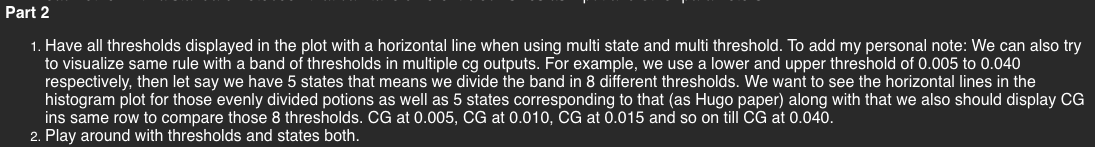